# Try out the NVIDIA Multimodal PDF Data Extraction Blueprint!

Welcome!

In this notebook, we will run inference on the new NVIDIA Multimodal PDF Data Extraction Blueprint. This blueprint uses a state-of-the-art multimodal model to extract data from PDFs, PowerPoints, and images. 


**Important Notes**: 
1. In order to run this notebook, you need to visit NGC and get a key for the Multimodal PDF Data Extraction Blueprint.

# Introduction

NVIDIA-Ingest is a scalable, performance-oriented document content and metadata extraction microservice. For more information, see [What is NVIDIA Ingest?](https://docs.nvidia.com/nemo/retriever/extraction/overview/).

# Architecture

This blueprint is comprised of multiple pieces that come together to form a powerful multi-modal RAG solution

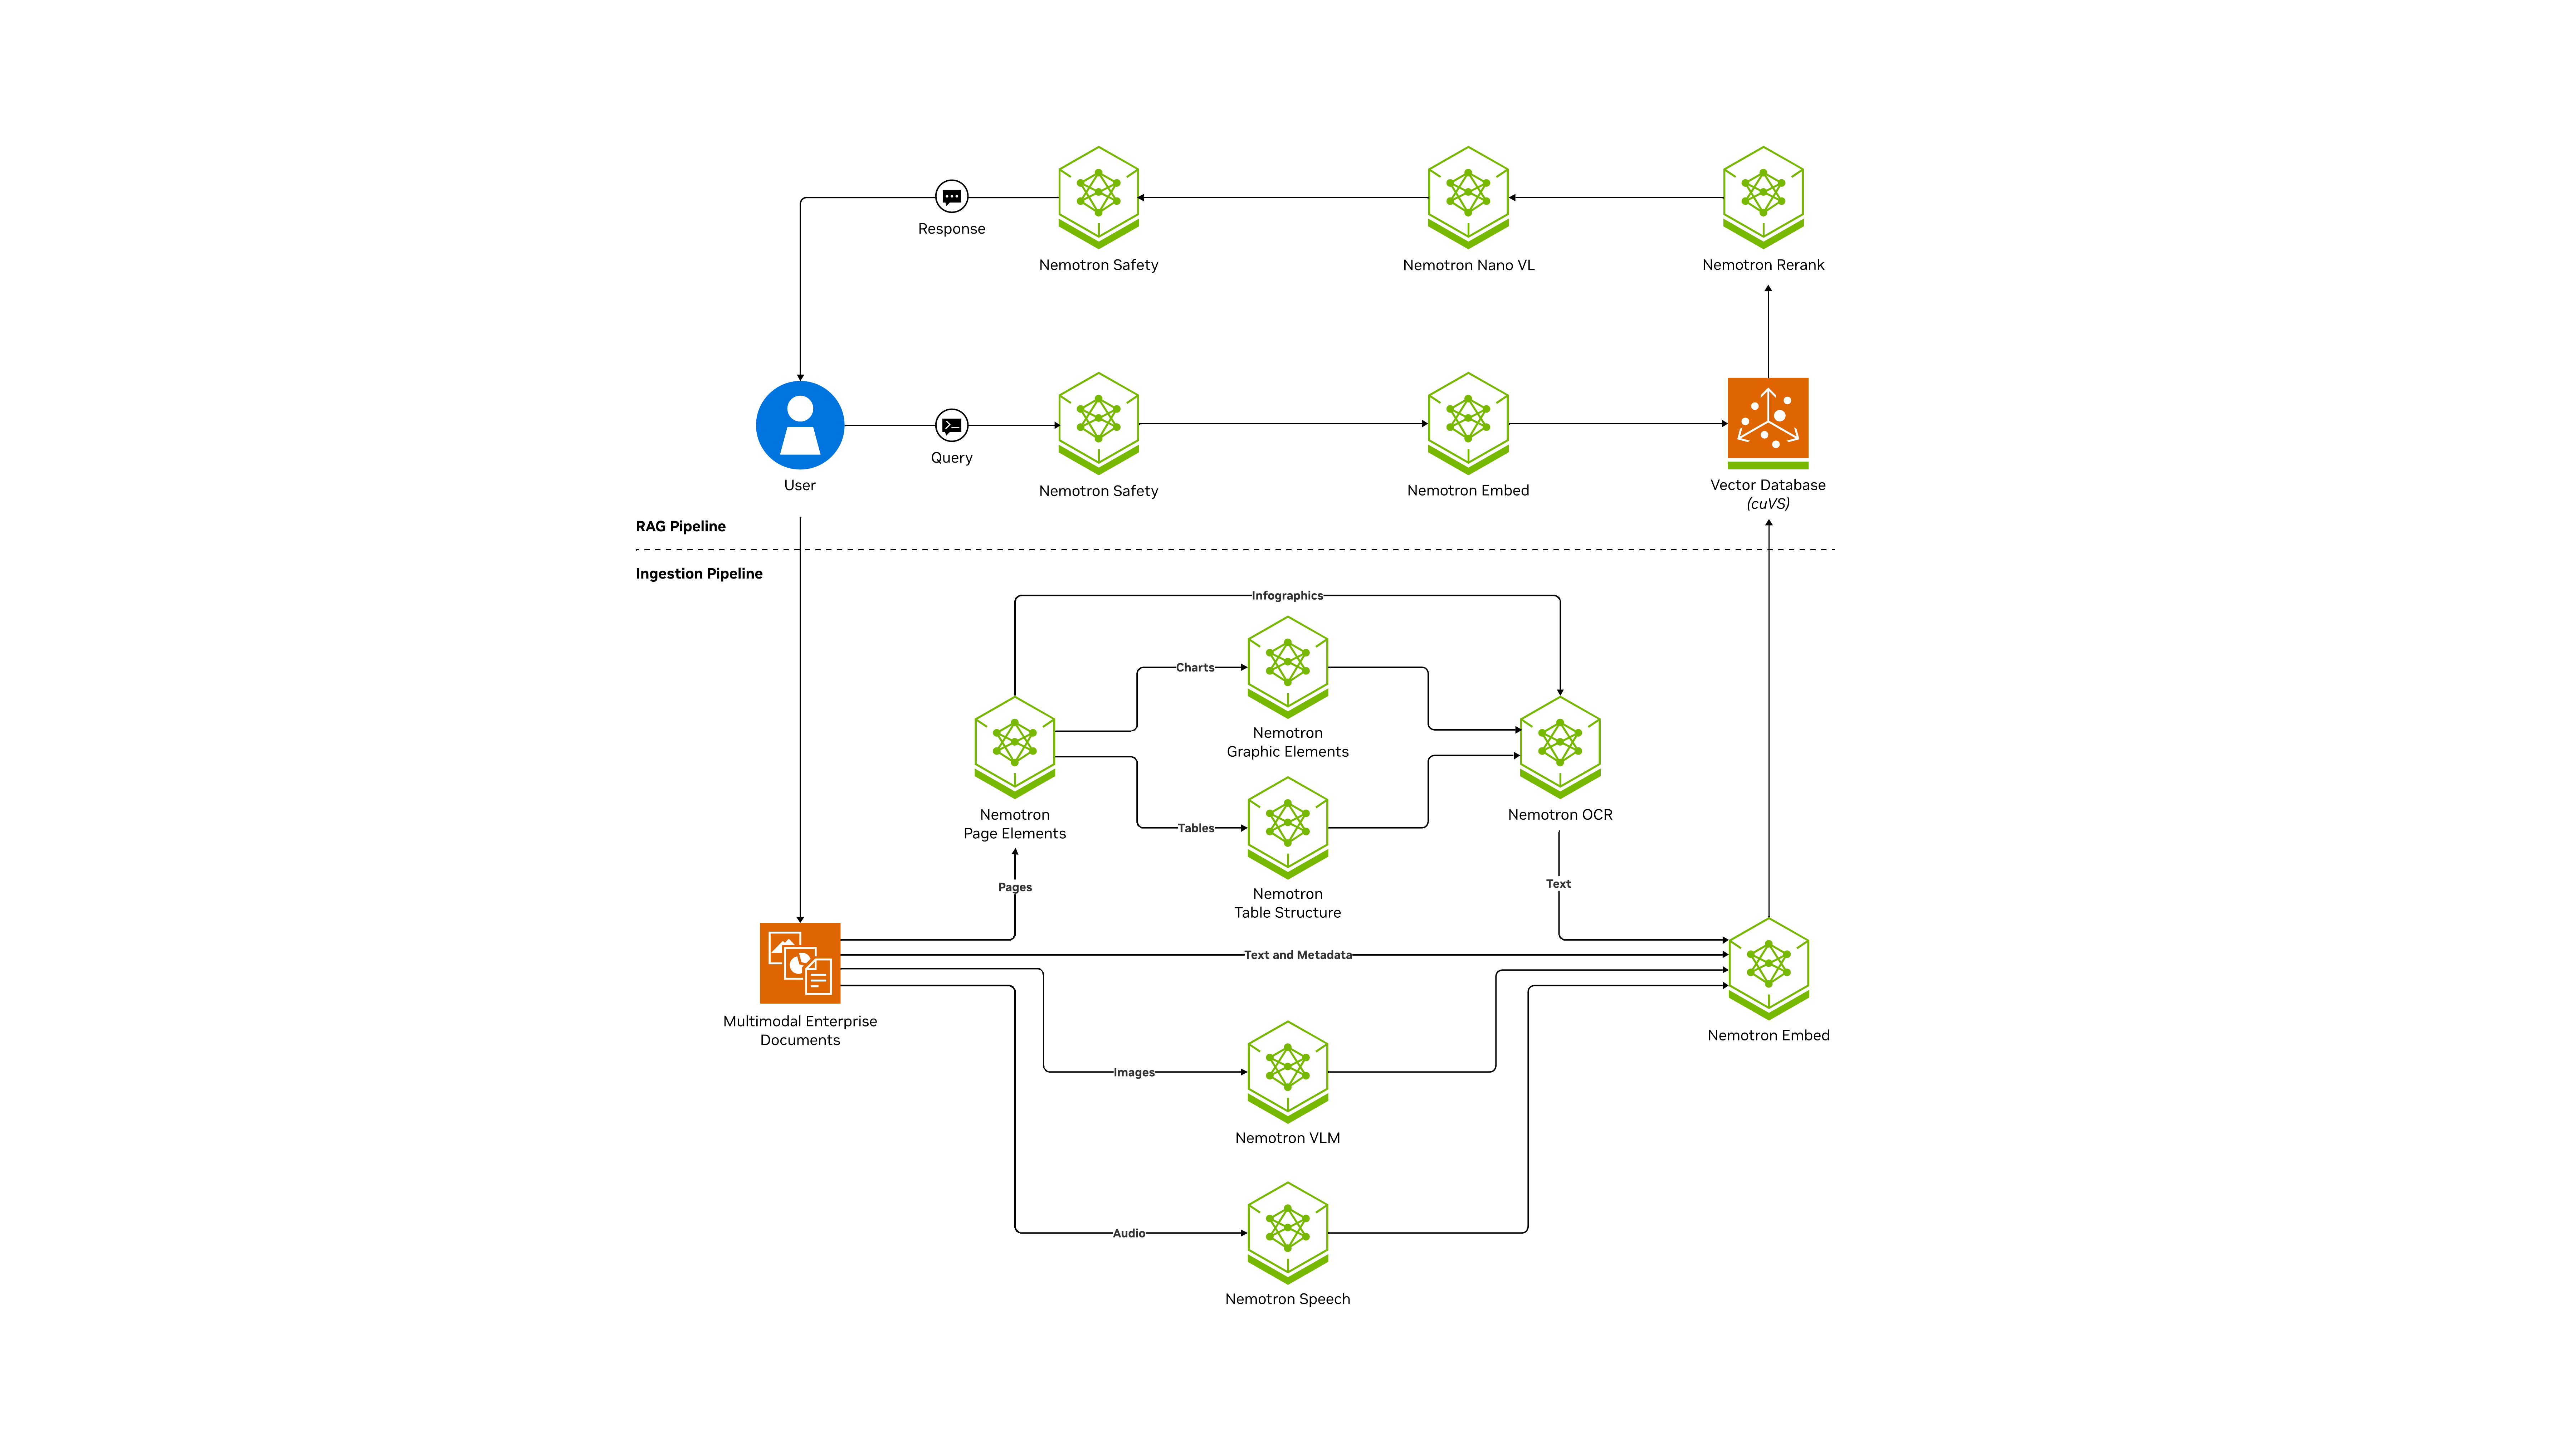

# Getting started

## Clone the repository and log into Docker

In order to spin up this blueprint, you will need an NGC api key. Talk to your NVIDIA rep or apply for access at [https://developer.nvidia.com/nemo-microservices](https://developer.nvidia.com/nemo-microservices). After you get your API key, paste it below where we run `export NGC_API_KEY=`.

In [ ]:
%%bash

[ -d "nv-ingest" ] || git clone https://github.com/nvidia/nv-ingest

cd nv-ingest
git checkout 25.9.0

export NGC_API_KEY=<enter-key-here>

echo "${NGC_API_KEY}" | docker login nvcr.io -u '$oauthtoken' --password-stdin

cat << EOF > .env
NGC_API_KEY=$NGC_API_KEY
DATASET_ROOT=/home/ubuntu/verb-workspace/data
NV_INGEST_ROOT=/home/ubuntu/verb-workspace/nv-ingest
EOF

echo ".env file has been created successfully."

Already on '25.6.2'


Your branch is up to date with 'origin/25.6.2'.
Login Succeeded
.env file has been created successfully.


## Spin up the blueprint

NOTE: This step can take about 10 minutes. The following steps are how we suggest running and monitoring your progress. If you do not want to monitor - you can simply run `docker compose --profile retrieval up -d` in a new terminal window

1. Open up a new terminal window and run the following

```bash
cd nv-ingest
docker compose --profile retrieval up
```

This will run each service and output persistant logs.

2. In a second terminal window, run

```bash
cd nv-ingest
docker compose logs -f nv-ingest-ms-runtime
```

This will show you persistant logs for the main `nv-ingest` service

### Checking for completion
Things should be spun up properly if the first part of your `nv-ingest-ms-runtime` logs show something similar to 

```bash
nv-ingest-ms-runtime-1  | INFO:     Uvicorn running on http://0.0.0.0:7670 (Press CTRL+C to quit)
nv-ingest-ms-runtime-1  | INFO:     Started parent process [20]
nv-ingest-ms-runtime-1  | INFO:     Started server process [40]
```

and the final lines look similar to 

```bash
nv-ingest-ms-runtime-1  | 2024-10-16 02:36:11,162 - DEBUG - parent_receive started child_thread
nv-ingest-ms-runtime-1  | 2024-10-16 02:36:11,162 - DEBUG - parent_receive started child_thread
nv-ingest-ms-runtime-1  | 2024-10-16 02:36:11,163 - DEBUG - parent_receive started child_thread
```

After everything is up and running, we can run `docker ps` and `nvidia-smi` 

In [ ]:
!docker ps

After you run `docker ps` you should see output similar to the following that lists your container images and the status of each. If any status includes `starting`, wait for the container to start before you proceed.

```text
CONTAINER ID   IMAGE                                        COMMAND                 CREATED            STATUS                      PORTS          
9869e432cc04   zilliz/attu:v2.3.5                           "docker-entrypoint.s…"  About an hour ago  Up About an hour            0.0.0.0:3001...
e02baf85ccc5   otel/opentelemetry-collector-contrib:0.91.0  "/otelcol-contrib --…"  About an hour ago  Up About an hour            0.0.0.0:4317...
4c3be36de11b   milvusdb/milvus:v2.5.3-gpu                   "/tini -- milvus run…"  About an hour ago  Up About an hour (healthy)  0.0.0.0:9091...
...
```


In [9]:
!nvidia-smi

Tue Jun 17 18:11:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   33C    P0             60W /  300W |   16553MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
!curl http://host.docker.internal:7670/v1/health/ready

{"ready":true}

# Interacting with the blueprint

There are 2 ways to interact with `nv-ingest`, a python client and a CLI. Lets use the Python client first 

## Installing the Python Client

In [ ]:
%%bash
pip install nv-ingest-client==25.9.0 \
    pymilvus[bulk_writer,model] \
    minio \
    tritonclient \
    langchain_milvus

## Using the python client 

Each ingest job will include a set of stages. These stages define and configure the operations that will be performed during ingestion of the specified input files.

- `extract` : Performs multimodal extractions from a document, including text, images, and tables.
- `split` : Chunk the text into smaller chunks, useful for storing in a vector database for retrieval applications.
- `dedup` : Identifies duplicate images in document that can be filtered to remove data redundancy.
- `filter` : Filters out images that are likely not useful using some heuristics, including size and aspect ratio.
- `embed` : Pass the text or table extractions through `"nvidia/nv-embedqa-e5-v5` NIM to obtain its embeddings.
- `store` : Save the extracted tables or images to MinIO, Milvus's storage system.

In [ ]:
from nv_ingest_client.client import Ingestor

# Load a sample PDF to demonstrate NV-Ingest usage.
ingestor = ( 
    Ingestor(message_client_hostname="host.docker.internal", message_client_port=7670)
    .files("./nv-ingest/data/multimodal_test.pdf") # can be a list of files, or contain wildcards i.e. /some/path/*.pdf
    .extract(
        extract_text=True,
        extract_tables=True,
        extract_charts=True,
        extract_images=True,
    ).split(
        tokenizer="meta-llama/Llama-3.2-1B",
        chunk_size=1024,
        chunk_overlap=150,
    ).embed( # whether to compute embeddings
        text=True, tables=True
    ) 
)

# Result is a List[List[Dict]] - Each outer list Item [] is a file and each inner list Item [][] is an element in that file
generated_metadata = ingestor.ingest()

In [13]:
from nv_ingest_client.util.process_json_files import ingest_json_results_to_blob

# generated_metadata is the result of a batch of submitted files. We sample the first file metadata here for demonstration purposes.
ingest_json_results_to_blob(generated_metadata[0])

'TestingDocument\r\nA sample document with headings and placeholder text\r\nIntroduction\r\nThis is a placeholder document that can be used for any purpose. It contains some \r\nheadings and some placeholder text to fill the space. The text is not important and contains \r\nno real value, but it is useful for testing. Below, we will have some simple tables and charts \r\nthat we can use to confirm Ingest is working as expected.\r\nTable 1\r\nThis table describes some animals, and some activities they might be doing in specific \r\nlocations.\r\nAnimal Activity Place\r\nGira@e Driving a car At the beach\r\nLion Putting on sunscreen At the park\r\nCat Jumping onto a laptop In a home o@ice\r\nDog Chasing a squirrel In the front yard\r\nChart 1\r\nThis chart shows some gadgets, and some very fictitious costs. Section One\r\nThis is the first section of the document. It has some more placeholder text to show how \r\nthe document looks like. The text is not meant to be meaningful or informat

## Explore the Outputs

Let's explore elements of the NV-Ingest output. When data flows through an NV-Ingest pipeline, a number of extractions and transformations are performed. As the data is enriched, it is stored in rich metadata hierarchy. In the end, there will be a list of dictionaries, each of which represents a extracted type of information. The most common elements to extract from a dictionary in this hierarchy are the extracted content and the text representation of this content. The next few cells will demonstrate interacting with the metadata, pulling out these elements, and visualizing them. Note, when there is a -1 value present, this represents non-applicable positional resolution. Positive numbers represent valid positional data.

For a more complete description of metadata elements, view the data dictionary.

https://github.com/NVIDIA/nv-ingest/blob/main/docs/docs/extraction/content-metadata.md

In [14]:
def redact_metadata_helper(metadata: dict) -> dict:
    """A simple helper function to redact `metadata["content"]` and metadata["embedding"]' to improve readability."""
    
    text_metadata_redact = metadata.copy()
    text_metadata_redact["metadata"]["content"] = "<---Redacted for readability--->"
    text_metadata_redact["metadata"]["embedding"] = "<---Redacted for readability--->"
    
    return text_metadata_redact

## Explore Output - Text

This cell depicts the full metadata hierarchy for a text extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, text in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source document that is the basis of the ingest job.
- `text_metadata` - Contain information about the text extraction, including detected language, among others - this section will only exist when `metadata['content_metadata']['document_type'] == 'text'`

In [15]:
redacted_text_metadata = redact_metadata_helper(generated_metadata[0][0])  # First file, first element of elements found within file [0][0]. There are 9 total
redacted_text_metadata

{'document_type': 'text',
 'metadata': {'content': '<---Redacted for readability--->',
  'content_url': '',
  'embedding': '<---Redacted for readability--->',
  'source_metadata': {'source_name': './nv-ingest/data/multimodal_test.pdf',
   'source_id': './nv-ingest/data/multimodal_test.pdf',
   'source_location': '',
   'source_type': 'PDF',
   'collection_id': '',
   'date_created': '2025-06-17T18:13:04.715946',
   'last_modified': '2025-06-17T18:13:04.715805',
   'summary': '',
   'partition_id': -1,
   'access_level': -1},
  'content_metadata': {'type': 'text',
   'description': 'Unstructured text from PDF document.',
   'page_number': -1,
   'hierarchy': {'page_count': 3,
    'page': -1,
    'block': -1,
    'line': -1,
    'span': -1,
    'nearby_objects': {'text': {'content': [], 'bbox': [], 'type': []},
     'images': {'content': [], 'bbox': [], 'type': []},
     'structured': {'content': [], 'bbox': [], 'type': []}}},
   'subtype': ''},
  'audio_metadata': None,
  'text_metadata

## Explore Output - Tables

This cell depicts the full metadata hierarchy for a table extraction with redacted content to ease readability. Notice the following sections are populated with information:

- `content` - The raw extracted content, a base64 encoded image of the extracted table in this case - this section will always be populated with a successful job.
- `content_metadata` - Describes the type of extraction and its position in the broader document - this section will always be populated with a successful job.
- `source_metadata` - Describes the source and storage path of an extracted table in an S3 compliant object store.
- `table_metadata` - Contains the text representation of the table, positional data, and other useful elements - this section will only exist when `metadata['content_metadata']['document_type'] == 'structured'`.

Note, `table_metadata` will store chart and table extractions. The are distringuished by `metadata['content_metadata']['subtype']`

In [16]:
redacted_table_metadata = redact_metadata_helper(generated_metadata[0][2])  # First file, third element within file [0][2]. There are 9 total
redacted_table_metadata

{'document_type': 'structured',
 'metadata': {'content': '<---Redacted for readability--->',
  'content_url': '',
  'embedding': '<---Redacted for readability--->',
  'source_metadata': {'source_name': './nv-ingest/data/multimodal_test.pdf',
   'source_id': './nv-ingest/data/multimodal_test.pdf',
   'source_location': '',
   'source_type': 'PDF',
   'collection_id': '',
   'date_created': '2025-06-17T18:13:04.715946',
   'last_modified': '2025-06-17T18:13:04.715805',
   'summary': '',
   'partition_id': -1,
   'access_level': -1},
  'content_metadata': {'type': 'structured',
   'description': 'Structured table extracted from PDF document.',
   'page_number': 0,
   'hierarchy': {'page_count': 3,
    'page': 0,
    'block': -1,
    'line': -1,
    'span': -1,
    'nearby_objects': {'text': {'content': [], 'bbox': [], 'type': []},
     'images': {'content': [], 'bbox': [], 'type': []},
     'structured': {'content': [], 'bbox': [], 'type': []}}},
   'subtype': 'table'},
  'audio_metadata'

## Using the CLI

The CLI is another way to interact with nv-ingest. Notice that we have encoded tasks in the `--tasks` flag. This will store outputs in a `processed_docs` folder

In [17]:
%%bash

nv-ingest-cli \
  --doc nv-ingest/data/multimodal_test.pdf \
  --output_directory ./processed_docs \
  --task='extract:{"document_type": "pdf", "extract_method": "pdfium", "extract_tables": "true", "extract_images": "true", "extract_charts": "true"}' \
  --client_host=host.docker.internal \
  --client_port=7670

python-dotenv could not parse statement starting at line 1
python-dotenv could not parse statement starting at line 2
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 4
python-dotenv could not parse statement starting at line 5
python-dotenv could not parse statement starting at line 6
python-dotenv could not parse statement starting at line 7
python-dotenv could not parse statement starting at line 8
python-dotenv could not parse statement starting at line 9
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12
python-dotenv could not parse statement starting at line 13
python-dotenv could not parse statement starting at line 14
python-dotenv could not parse statement starting at line 15
python-dotenv could not parse statement starting at line 16
python-dotenv could not parse statement starting 

# Building an E2E reranking and retreival pipeline

Reranking is crucial for achieving high accuracy and efficiency in retrieval pipelines. It plays a vital role, particularly when the pipeline incorporates citations from diverse datastores, where each datastore may employ its own unique similarity scoring algorithm. Reranking serves two primary purposes:

1. Improving accuracy for individual citations within each datastore.
2. Integrating results from multiple datastores to provide a cohesive and relevant set of citations.

We'll be using a couple different NIMs for this pipeline. These are a combination of models running locally and hosted on [build.nvidia.com]. However, all of these can be self hosted!
1. `llama-3.2-nv-embedqa-1b-v2`: this will serve as our embedding model. `nv-ingest` will use this in the `VdbUploadTask`
2. `nv-rerankqa-mistral-4b-v3`: this will be our reranking model
3. `llama-3.1-nemotron-70b-instruct`: NVIDIA's new SOTA model for our LLM

For this example, lets use the table in the `woods_frost.pdf`. For reference, here it is 

| # | Collection | Year |
|---|------------|------|
| 1 | A Boy's Will | 1913 |
| 2 | North of Boston | 1914 |
| 3 | Mountain Interval | 1916 |
| 4 | New Hampshire | 1923 |
| 5 | West Running Brook | 1928 |
| 6 | A Further Range | 1937 |
| 7 | A Witness Tree | 1942 |
| 8 | In the Clearing | 1962 |
| 9 | Steeple Bush | 1947 |
| 10 | An Afterword | unknown |

This table lists various poetry collections by Robert Frost, along with their publication years. Note that the year for "An Afterword" is listed as unknown.

Note: this demo is hosted live on  [build.nvidia.com](https://build.nvidia.com/nvidia/multimodal-pdf-data-extraction-for-enterprise-rag)

## Checking and installing dependancies

In [18]:
# ensure that we have the embedding model up
!docker ps | grep embed

3127aeb92c64   nvcr.io/nim/nvidia/llama-3.2-nv-embedqa-1b-v2:1.6.0          "/opt/nim/start_serv…"   20 hours ago   Up 11 minutes             0.0.0.0:8012->8000/tcp, [::]:8012->8000/tcp, 0.0.0.0:8013->8001/tcp, [::]:8013->8001/tcp, 0.0.0.0:8014->8002/tcp, [::]:8014->8002/tcp   nv-ingest-embedding-1


In [19]:
# ensure we have milvusdb up
!docker ps | grep milvusdb

c535a610498c   milvusdb/milvus:v2.5.3-gpu                                   "/tini -- milvus run…"   20 hours ago   Up 30 minutes (healthy)   0.0.0.0:9091->9091/tcp, [::]:9091->9091/tcp, 0.0.0.0:19530->19530/tcp, [::]:19530->19530/tcp                                            milvus-standalone


## Testing with no pipeline

Lets see what our LLM knows about Robert Frost's poetry

In [20]:
# generate an API key from build.nvidia.com for hosted models
import os

# NOTE: You should surround this value with ""
NVIDIA_API_KEY=<enter-key-here>

In [21]:
from openai import OpenAI

client = OpenAI(
  base_url = "https://integrate.api.nvidia.com/v1",
  api_key = NVIDIA_API_KEY
)

completion = client.chat.completions.create(
  model="nvidia/llama-3.1-nemotron-70b-instruct",
  messages=[{"role":"user","content":"What are Robert Frosts poetry collections. Provide the name and year."}],
  temperature=0.5,
  top_p=1,
  max_tokens=1024,
  stream=True
)

for chunk in completion:
  if chunk.choices[0].delta.content is not None:
    print(chunk.choices[0].delta.content, end="")

Here are the poetry collections of Robert Frost, listed in chronological order by publication year:

1. **A Boy's Will** (1913)
2. **North of Boston** (1914)
3. **Mountain Interval** (1924)
4. **New Hampshire** (1923) *won the Pulitzer Prize for Poetry in 1924*
5. **Collected Poems** (1930)
6. **Further Range** (1936) *won the Pulitzer Prize for Poetry in 1937*
7. **A Witness Tree** (1942) *won the Pulitzer Prize for Poetry in 1943*
8. **Come In, and Other Poems** (1943)
9. **Steeple Bush** (1947)
10. **Complete Poems of Robert Frost** (1949)
11. **In the Clearing** (1962)
12. **The Poetry of Robert Frost** (1969) *published posthumously, edited by Edward Connery Lathem*

Note: There have been numerous posthumous collections, anthologies, and editions of Frost's poetry, but the above list includes the primary collections published during his lifetime.

## With pipeline

Our model got some of them but also included some selected works that we were not looking for. Lets see if we can improve this response

### Pipeline section 1: Extraction

We first extract the document metadata using nv-ingest.

In [22]:
from nv_ingest_client.client import Ingestor
from nv_ingest_client.util.file_processing.extract import extract_file_content

file_content, file_type = extract_file_content("./nv-ingest/data/woods_frost.pdf")

# Load a sample PDF to demonstrate NV-Ingest usage.
ingestor = (
    Ingestor(message_client_hostname="host.docker.internal", message_client_port=7670)
    .files("./nv-ingest/data/woods_frost.pdf") # can be a list of files, or contain wildcards i.e. /some/path/*.pdf
    .extract(
        extract_text=True,
        extract_tables=True,
        extract_charts=True,
        extract_images=True,
    ).split(
        tokenizer="meta-llama/Llama-3.2-1B",
        chunk_size=1024,
        chunk_overlap=150,
    ).embed()
)

generated_metadata = ingestor.ingest()

### Pipeline section 2: Visualize metadata 

Below we provide some helper functions that can be used to analyze the metadata

In [23]:
from collections import Counter
from typing import List, Dict, Any
from base64 import b64decode
from IPython.display import display, Image

def count_metadata_types(metadata: List[Dict[str, Any]]) -> Dict[str, int]:
    """
    Count the number of each metadata type in the generated metadata.
    """
    return dict(Counter(item['document_type'] for item in metadata))

def analyze_text_metadata(metadata: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Analyze text metadata and return key information.
    """
    text_items = [item for item in metadata if item['document_type'] == 'text']
    if not text_items:
        return {"error": "No text metadata found"}
    
    text_item = text_items[0]['metadata']
    return {
        "language": text_item['text_metadata']['language'],
        "page_count": text_item['content_metadata']['hierarchy']['page_count'],
        "source_name": text_item['source_metadata']['source_name'],
        "content_preview": text_item['content'][:200] + "..."  # First 200 characters
    }

def analyze_table_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze table metadata and return key information for each table.
    """
    table_items = [item['metadata'] for item in metadata 
                   if item['document_type'] == 'structured' 
                   and item['metadata']['content_metadata']['subtype'] == 'table']
    
    return [{
        "content_preview": table['table_metadata']['table_content'][:100] + "...",
        "location": table['table_metadata']['table_location'],
        "page_number": table['content_metadata']['page_number']
    } for table in table_items]

def analyze_chart_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze chart metadata and return key information for each chart.
    """
    chart_items = [item['metadata'] for item in metadata 
                   if item['document_type'] == 'structured' 
                   and item['metadata']['content_metadata']['subtype'] == 'chart']
    
    return [{
        "content_preview": chart['table_metadata']['table_content'][:100] + "...",
        "location": chart['table_metadata']['table_location'],
        "page_number": chart['content_metadata']['page_number']
    } for chart in chart_items]

def analyze_image_metadata(metadata: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Analyze image metadata and return key information for each image.
    """
    image_items = [item['metadata'] for item in metadata if item['document_type'] == 'image']
    
    return [{
        "image_type": img['image_metadata']['image_type'],
        "dimensions": f"{img['image_metadata']['width']}x{img['image_metadata']['height']}",
        "location": img['image_metadata']['image_location'],
        "page_number": img['content_metadata']['page_number']
    } for img in image_items]

def display_image(metadata: List[Dict[str, Any]], index: int = 0):
    """
    Display an image from the metadata at the specified index.
    """
    image_items = [item for item in metadata if item['document_type'] == 'image']
    if index < 0 or index >= len(image_items):
        print(f"Invalid index. There are {len(image_items)} images.")
        return
    
    image_data = b64decode(image_items[index]['metadata']['content'])
    display(Image(image_data))

def comprehensive_metadata_analysis(metadata: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Perform a comprehensive analysis of the metadata and return a summary.
    """
    return {
        "type_counts": count_metadata_types(metadata),
        "text_analysis": analyze_text_metadata(metadata),
        "table_analysis": analyze_table_metadata(metadata),
        "chart_analysis": analyze_chart_metadata(metadata),
        "image_analysis": analyze_image_metadata(metadata)
    }

def print_metadata_summary(analysis: Dict[str, Any]):
    """
    Print a formatted summary of the metadata analysis.
    """
    print("NV-Ingest Metadata Analysis Summary")
    print("===================================")
    
    print("\nMetadata Type Counts:")
    for doc_type, count in analysis['type_counts'].items():
        print(f"  {doc_type}: {count}")
    
    print("\nText Analysis:")
    text_analysis = analysis['text_analysis']
    print(f"  Language: {text_analysis['language']}")
    print(f"  Page Count: {text_analysis['page_count']}")
    print(f"  Source Name: {text_analysis['source_name']}")
    print(f"  Content Preview: {text_analysis['content_preview']}")
    
    print("\nTable Analysis:")
    for i, table in enumerate(analysis['table_analysis'], 1):
        print(f"  Table {i}:")
        print(f"    Content Preview: {table['content_preview']}")
        print(f"    Location: {table['location']}")
        print(f"    Page Number: {table['page_number']}")
    
    print("\nChart Analysis:")
    for i, chart in enumerate(analysis['chart_analysis'], 1):
        print(f"  Chart {i}:")
        print(f"    Content Preview: {chart['content_preview']}")
        print(f"    Location: {chart['location']}")
        print(f"    Page Number: {chart['page_number']}")
    
    print("\nImage Analysis:")
    for i, image in enumerate(analysis['image_analysis'], 1):
        print(f"  Image {i}:")
        print(f"    Type: {image['image_type']}")
        print(f"    Dimensions: {image['dimensions']}")
        print(f"    Location: {image['location']}")
        print(f"    Page Number: {image['page_number']}")

NV-Ingest Metadata Analysis Summary

Metadata Type Counts:
  text: 1
  structured: 1
  image: 4

Text Analysis:
  Language: en
  Page Count: 2
  Source Name: ./nv-ingest/data/woods_frost.pdf
  Content Preview: Stopping by Woods on a Snowy Evening, By Robert Frost
Figure 1: Snowy Woods
Whose woods these are I think I know. His house is in the village though; He will not see me 
stopping here; To watch his...

Table Analysis:
  Table 1:
    Content Preview: | # | Collection | Year |
| 1 | A Boy's Will | 1913 |
| 2 | North of Boston | 1914 |
| 3 | Mountain ...
    Location: [89, 29, 697, 379]
    Page Number: 1

Chart Analysis:

Image Analysis:
  Image 1:
    Type: png
    Dimensions: 227x166
    Location: [72, 91, 299, 257]
    Page Number: 0
  Image 2:
    Type: png
    Dimensions: 129x194
    Location: [72, 476, 201, 670]
    Page Number: 0
  Image 3:
    Type: png
    Dimensions: 483x169
    Location: [58, 288, 541, 457]
    Page Number: 0
  Image 4:
    Type: png
    Dimensions: 483x

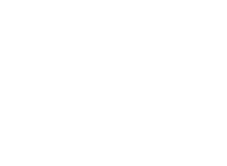

In [24]:
analysis = comprehensive_metadata_analysis(generated_metadata[0])  # One analyze first file result
print_metadata_summary(analysis)

# To display an image:
display_image(generated_metadata[0], 0)  # Display the first image

### Pipeline section 3: Embedding, Storage, and Saving to a Vector DB

We now create our Milvus collection and bulk upload our nv-ingest `generated_metadata` to the collection from Minio.

In [25]:
from nv_ingest_client.util.milvus import create_nvingest_collection, write_to_nvingest_collection

sparse = False
COLLECTION_NAME="nv_ingest_collection"

# Create the Milvus collection
schema = create_nvingest_collection(COLLECTION_NAME, f"http://host.docker.internal:19530", sparse=sparse, dense_dim=2048)

In [26]:
# Index the nv-ingest generated_metadata to the Milvus collection
write_to_nvingest_collection(generated_metadata, COLLECTION_NAME, sparse=sparse, milvus_uri=f"http://host.docker.internal:19530", minio_endpoint="host.docker.internal:9000")

### Pipeline section 4: Connect to MilvusDB and the embedding model to start querying

In [27]:
import os
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings, NVIDIARerank, ChatNVIDIA
from langchain_milvus import Milvus

# TODO: Add your NVIDIA API key here
os.environ["NVIDIA_API_KEY"] = NVIDIA_API_KEY

embedding = NVIDIAEmbeddings(base_url="http://host.docker.internal:8012/v1")

reranker = NVIDIARerank(model="nvidia/nv-rerankqa-mistral-4b-v3")

llm = ChatNVIDIA(model="nvidia/llama-3.1-nemotron-70b-instruct")

vectorstore = Milvus(
    embedding_function=embedding,
    collection_name=COLLECTION_NAME,
    primary_field = "pk",
    vector_field = "vector",
    text_field="text",
    connection_args={"uri": "http://host.docker.internal:19530"},
)
retriever = vectorstore.as_retriever()

/home/ubuntu/.pyenv/versions/3.12.11/lib/python3.12/site-packages/langchain_nvidia_ai_endpoints/_common.py:242: UserWarning: Default model is set as: nvidia/llama-3.2-nv-embedqa-1b-v2. 
Set model using model parameter. 
To get available models use available_models property.
  warnings.warn(
2025-06-17 18:15:15,085 [DEBUG][_create_connection]: Created new connection using: 9add41a258b44dbba039250be903ac41 (async_milvus_client.py:599)


In [28]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Keep the answer concise."
    "\n\n"
    "{context}"
    "Question: {question}"
)

prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)
resp=rag_chain.invoke("What are Robert Frosts poetry collections. Provide the name and year.?")

print(resp)

Based on the retrieved context, here are Robert Frost's poetry collections with their corresponding years:

1. **A Boy's Will** (1913)
2. **North of Boston** (1914)
3. **Mountain Interval** (1916)
4. **New Hampshire** (1923)
5. **West Running Brook** (1928)
6. **A Further Range** (1937)
7. **A Witness Tree** (1942)
8. **Steeple Bush** (1947)
9. **In the Clearing** (1962)
10. **An Afterword** (unknown/year not specified)
